## Chatbot

### Input library

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import re
import json
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd

### load dataset dan preparation

In [2]:


with open('dataset3.json') as f:
    data = json.load(f)

# Load the additional corpus from corpus.json
with open('dataset/corpus/id/agent.json') as f:
    agent = json.load(f)

with open('dataset/corpus/id/dialog.json') as f:
    dialog = json.load(f)

with open('dataset/corpus/id/motivasi.json') as f:
    motivation = json.load(f)

with open('dataset/corpus/id/None.json') as f:
    none = json.load(f)

with open('dataset/corpus/id/user.json') as f:
    user = json.load(f)



# Append the corpus data to the existing data
data['intents'].extend(agent)
data['intents'].extend(dialog)
data['intents'].extend(motivation)
data['intents'].extend(none)
data['intents'].extend(user)


stop_words = set()

with open('stopword_id.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stop_words.add(line.strip())

tags = []
inputs = []
responses = {}
lemmatizer = WordNetLemmatizer()

for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for line in intent['patterns']:
        # Prapemrosesan teks
        line = re.sub('[.,’"\'-?:!;]', '', line)
        
        # Tokenize each word in the pattern
        w = nltk.word_tokenize(line)
        w = [lemmatizer.lemmatize(word.lower()) for word in w if word not in stop_words]
        inputs.append(' '.join(w))
        tags.append(intent['tag'])

# Create a DataFrame
data_df = pd.DataFrame({"inputs": inputs, "tags": tags})


### print dataset setelah preparation

In [3]:
print(data_df)

                     inputs                    tags
0            apa feminicare      tentang_feminicare
1                feminicare      tentang_feminicare
2    definisikan feminicare      tentang_feminicare
3            apa feminicare      tentang_feminicare
4                feminicare      tentang_feminicare
..                      ...                     ...
907                 lakukan        user.needsadvice
908                          user.permission_to_ask
909                          user.permission_to_ask
910                          user.permission_to_ask
911                   nanya  user.permission_to_ask

[912 rows x 2 columns]


In [4]:
data_df.to_csv('output.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.


### preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenizer
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(data_df['inputs'])

# Encode the outputs
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(data_df['tags'])

# Define input shape
max_len = max(len(sequence) for sequence in sequences) 
# multinomial nb


# Padding sequences
sequences = tokenizer.texts_to_sequences(data_df['inputs'])
x_train = pad_sequences(sequences, maxlen=max_len, truncating='post')

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


### inisialisasi layer

In [5]:
model = Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 64, input_length=max_len),
    tf.keras.layers.LSTM(2, return_sequences=True), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax'),
])


# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['precision'])



### training model

In [6]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
23/23 [==============================] - 5s 126ms/step - loss: 5.4764 - accuracy: 0.0041 - val_loss: 5.4537 - val_accuracy: 0.0055
Epoch 2/100
23/23 [==============================] - 2s 87ms/step - loss: 5.4303 - accuracy: 0.0165 - val_loss: 5.5911 - val_accuracy: 0.0000e+00
Epoch 3/100
23/23 [==============================] - 2s 85ms/step - loss: 5.3984 - accuracy: 0.0082 - val_loss: 5.6561 - val_accuracy: 0.0109
Epoch 4/100
23/23 [==============================] - 2s 99ms/step - loss: 5.3651 - accuracy: 0.0151 - val_loss: 5.5937 - val_accuracy: 0.0109
Epoch 5/100
23/23 [==============================] - 2s 94ms/step - loss: 5.3314 - accuracy: 0.0151 - val_loss: 5.6145 - val_accuracy: 0.0109
Epoch 6/100
23/23 [==============================] - 2s 96ms/step - loss: 5.2734 - accuracy: 0.0192 - val_loss: 5.6470 - val_accuracy: 0.0273
Epoch 7/100
23/23 [==============================] - 2s 103ms/step - loss: 5.1521 - accuracy: 0.0549 - val_loss: 5.4174 - val_accuracy: 0.0437


### plot akurasi

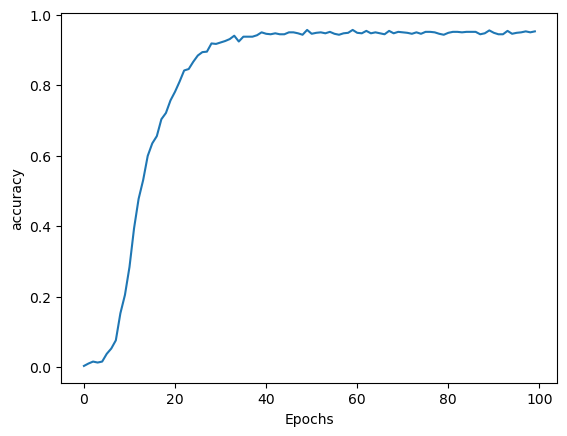

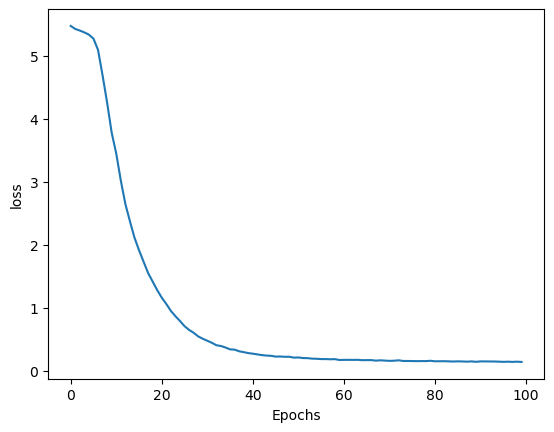

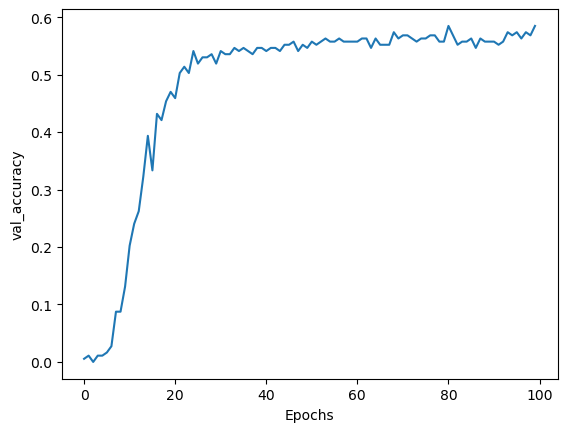

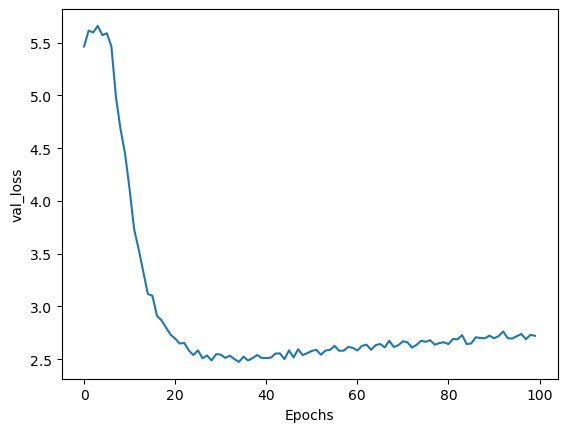

In [7]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [8]:
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

# Load stopwords from file
with open('stopword_id.txt', 'r', encoding='utf-8') as stopword_file:
    stop_words = stopword_file.read().splitlines()

# Load normalization rules from file
with open('normalization.txt', 'r', encoding='utf-8') as normalization_file:
    normalization_rules = dict(line.strip().split('\t') for line in normalization_file)

# Load slangword definitions from file
with open('slangword.txt', 'r', encoding='utf-8') as slangword_file:
    slangword_definitions = dict(line.strip().split(':') for line in slangword_file)


def preprocess_input(user_input):
    # Convert to lowercase
    user_input = user_input.lower()

    # Remove characters not in [a-zA-Z0-9\s]
    user_input = user_input.lower()
    user_input = re.sub(r'[.,’"\'-?:!;]', '', user_input)

    # Normalize using rules from normalization.txt
    for key, value in normalization_rules.items():
        user_input = user_input.replace(key, value)
    
    # Replace slangwords with their definitions
    for key, value in slangword_definitions.items():
        user_input = user_input.replace(key, value)

    # Remove punctuation
    user_input = user_input.translate(str.maketrans("", "", string.punctuation))

    # Tokenize the input
    words = word_tokenize(user_input)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Correct typos using fuzzy matching
    corrected_words = []
    for word in words:
        max_similarity = 0
        corrected_word = word

        for reference_word in stop_words:
            similarity = fuzz.ratio(word, reference_word)
            if similarity > max_similarity:
                max_similarity = similarity
                corrected_word = reference_word

        corrected_words.append(corrected_word)

    # Join the corrected words
    preprocessed_text = ' '.join(corrected_words)

    # Remove extra whitespaces
    preprocessed_text = re.sub(' +', ' ', preprocessed_text)

    return preprocessed_text

### check output 

In [9]:
import random
from fuzzywuzzy import fuzz


while True:
    user_input = input('You: ')
    preprocessed_text = preprocess_input(user_input)
    if preprocessed_text.lower() == 'goodbye':
        print("Chatbot: Goodbye!")
        break
    try:
        input_seq = tokenizer.texts_to_sequences([preprocessed_text])
        input_seq = pad_sequences(input_seq, maxlen=input_shape)
        predicted_label_seq = model.predict(input_seq)
        predicted_label = label_encoder.inverse_transform([predicted_label_seq.argmax(axis=-1)])[0]
        # print("tags:", predicted_label)

        # Pilih respons dari kategori tag
        responses_for_tag = responses.get(predicted_label, ["Chatbot: Maaf, saya tidak memahami maksud Anda."])
        response = random.choice(responses_for_tag)
        
        print("Chatbot:", response)
    except:
        print("Chatbot: Maaf, saya tidak memahami maksud Anda.")


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


1/1 [==============================] - 0s 386ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: agent.acquaintance
Chatbot: Saya adalah feminicare
1/1 [==============================] - 0s 22ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: perawatan_diri_selama_menstruasi
Chatbot: Untuk merawat diri selama menstruasi dengan baik, Anda dapat mengambil langkah-langkah seperti merencanakan waktu istirahat ekstra, menggunakan metode penghilang nyeri seperti panas atau pijatan perut, dan menjaga kebersihan diri dengan mengganti pembalut atau alat menstruasi sesuai kebutuhan. Selain itu, perhatikan pola makan yang sehat dan hindari makanan yang dapat memperburuk gejala menstruasi.
1/1 [==============================] - 0s 22ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: perawatan_diri_selama_menstruasi
Chatbot: Untuk merawat diri selama menstruasi dengan baik, Anda dapat mengambil langkah-langkah seperti merencanakan waktu istirahat ekstra, menggunakan metode penghilang nyeri seperti panas atau pijatan perut, dan menjaga kebersihan diri dengan mengganti pembalut atau alat menstruasi sesuai kebutuhan. Selain itu, perhatikan pola makan yang sehat dan hindari makanan yang dapat memperburuk gejala menstruasi.
1/1 [==============================] - 0s 44ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: agent.acquaintance
Chatbot:  Saya adalah aplikasi percakapan 
1/1 [==============================] - 0s 22ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: greetings.bye
Chatbot: sampai jumpa lagi!
